In [36]:
from sklearn import preprocessing
from sklearn import cluster
from sklearn import model_selection
from sklearn import feature_selection
from sklearn import decomposition
from sklearn import manifold
from sklearn import metrics
from sklearn import tree
from sklearn import neighbors 

import numpy as np
import matplotlib.pyplot as plt
import pandas

from IPython.display import Image
from sklearn.externals.six import StringIO
import pydot
import os

os.environ['PATH'] = os.environ['PATH']+ ';C:\\Program Files (x86)\\Graphviz2.38\\bin'

%matplotlib inline


seed = 11

fname   = 'Crimes_-_2001_to_present.csv'

datadir = './Data/'

In [38]:
def plot_silhouette(svalues,
                    clusters,
                    ax=None,
                    title="The silhouette plot for the various clusters.",
                    xlabel="The silhouette coefficient values",
                    ylabel="Cluster label",
                    cluster_fontsize = 12,
                    **kwargs):
    CLUS_COLORS = ['#000000', '#ff5555', '#00BB55', '#5555ff',
                   '#55ffff', '#ffff55', '#4F3101', '#EB9AEC',
                   '#0000ff', '#999999', '#ffbb44']
    """
     Plot silhouette plot
    """
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=kwargs.get('figsize', (10, 10)))
    n_clusters = len(np.unique(clusters))
    y_lower = 10
    # The silhouette coefficient can range from -1, 1 but in this example all
    ax.set_xlim([np.min(svalues), 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(svalues) + (n_clusters + 1) * 10])
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = svalues[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = CLUS_COLORS[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.95)
        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=cluster_fontsize)
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.axvline(x=np.mean(svalues), linestyle=':', color='#0066CC')
    ax.text(0.7, 0.01, u'Average: %.02f ' % np.mean(svalues),
            verticalalignment='bottom', horizontalalignment='right',
            color='#0066CC',
            transform=ax.transAxes, fontsize=15)


    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_yticks([])
    #fig.tight_layout()
    return ax

# Load Data 

In [39]:
df = pandas.read_csv(datadir + fname, sep = ',')
df.loc[:,'Date'] = pandas.to_datetime(df.Date, format='%m/%d/%Y %I:%M:%S %p')
df['DateMonth'] = df['Date'].values.astype('datetime64[M]')
df['Hour'] = df['Date'].dt.hour
print(df.shape)
print(df.columns)

(10000, 23)
Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'DateMonth', 'Hour'],
      dtype='object')


# Data Preparation 

In [40]:
# Features: % of crimes, per type, for each district. 
# Segment districts according to its crime profile.

crimes = ['ROBBERY', 'DECEPTIVE PRACTICE', 'MOTOR VEHICLE THEFT', 'BURGLARY',
          'ASSAULT', 'OTHER OFFENSE', 'NARCOTICS', 'CRIMINAL DAMAGE', 'BATTERY',
          'THEFT']
data = df[df['Primary Type'].isin(crimes)]
data = data.groupby(['Primary Type','District'], as_index=False)['ID'].count()
data = data.pivot('Primary Type','District','ID')
data.fillna(0, inplace=True)
data = data.T
features = data.columns.values
districts= data.index.values

## Pre-processing 

In [41]:
if False:
    scaler = preprocessing.StandardScaler()
    scaler.fit(data.values)
    data = scaler.transform(data.values)
else:
    data = data.values

# Hierarchical 

Text(0.5,1,'Hierarchical Clustering')

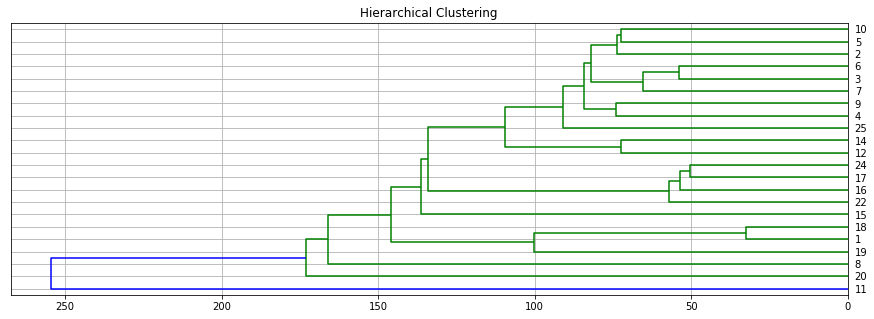

In [42]:
from scipy.cluster import hierarchy

plt.figure(figsize=(15,5))
X = hierarchy.linkage(metrics.euclidean_distances(data), 'single')
hierarchy.dendrogram(X, orientation='left', labels=districts)
plt.grid()
plt.title('Hierarchical Clustering')

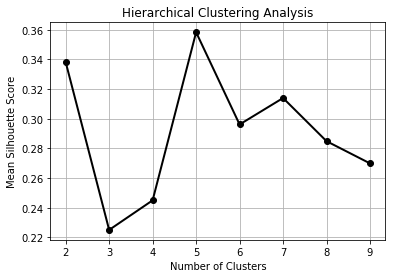

In [43]:
# Create a graph capturing local connectivity. Larger number of neighbors
# will give more homogeneous clusters to the cost of computation
# time. A very large number of neighbors gives more evenly distributed
# cluster sizes, but may not impose the local manifold structure of
# the data
nclusters = np.arange(2, 10)
ss_scores = []
linkage = 'average'
for n in nclusters:
    model = cluster.AgglomerativeClustering(linkage=linkage,
                                            connectivity=None,
                                            n_clusters=n)
    model.fit(data)
    ss_scores.append(metrics.silhouette_score(data, model.labels_))    
# Plot
plt.plot(nclusters, ss_scores, 'o-k', lw=2)
plt.title('Hierarchical Clustering Analysis')
plt.xlabel('Number of Clusters')
plt.ylabel('Mean Silhouette Score')
plt.grid()

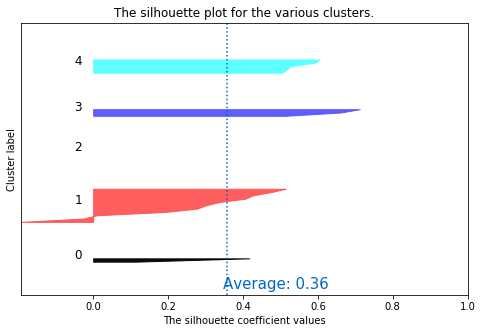

In [53]:
ncluster = 5
ag_model = cluster.AgglomerativeClustering(linkage=linkage,
                                             connectivity=None,
                                             n_clusters=ncluster)
ag_model.fit(data)
ag_clusters = ag_model.labels_
ss_avg = metrics.silhouette_score(data, ag_clusters)
ss_scores = metrics.silhouette_samples(data, ag_clusters)
plt.figure(figsize=(8,5))
plot_silhouette(ss_scores, ag_clusters, ax = plt.gca())

# K-Means 

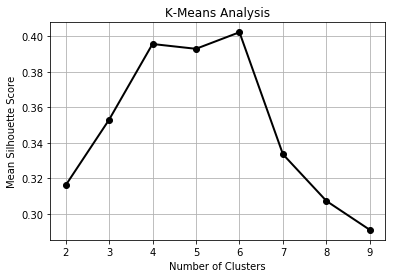

In [45]:
nclusters = np.arange(2, 10)
ss_scores = []
for n in nclusters:
    km = cluster.KMeans(n_clusters=n, n_init=10, init='k-means++')
    km.fit(data)
    ss_scores.append(metrics.silhouette_score(data, km.predict(data)))
# Plot
plt.plot(nclusters, ss_scores, 'o-k', lw=2)
plt.title('K-Means Analysis')
plt.xlabel('Number of Clusters')
plt.ylabel('Mean Silhouette Score')
plt.grid()

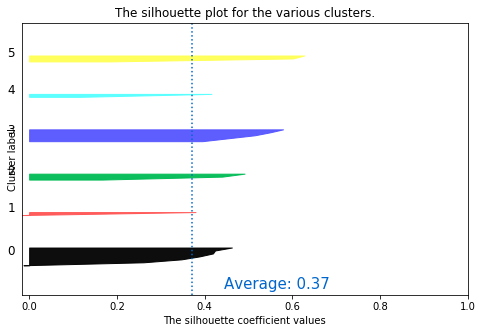

In [54]:
ncluster = 6

km = cluster.KMeans(n_clusters=ncluster, n_init=10, init='k-means++')
km.fit(data)
km_clusters = km.predict(data)
ss_avg = metrics.silhouette_score(data, km_clusters)
ss_scores = metrics.silhouette_samples(data, km_clusters)
plt.figure(figsize=(8,5))
plot_silhouette(ss_scores, km_clusters, ax = plt.gca())

# Visualization

## t-SNE

Text(0,0.5,'Dim 2')

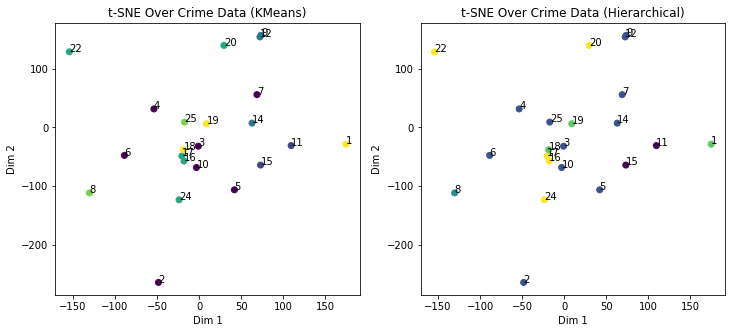

In [55]:
tsne = manifold.TSNE(random_state=seed)
Y = tsne.fit_transform(data) * 1e6

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(Y[:, 0], Y[:, 1], c=km_clusters)
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('t-SNE Over Crime Data (KMeans)')
for i in range(Y.shape[0]):
    plt.gca().annotate('%i'%(districts[i]), (Y[i,0]+0.01, Y[i,1]+0.01))


plt.subplot(1,2,2)
plt.scatter(Y[:, 0], Y[:, 1], c=ag_clusters)
plt.title('t-SNE Over Crime Data (Hierarchical)')
for i in range(Y.shape[0]):
    plt.gca().annotate('%i'%(districts[i]), (Y[i,0]+0.01, Y[i,1]+0.01))
    
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')


## Isomap 

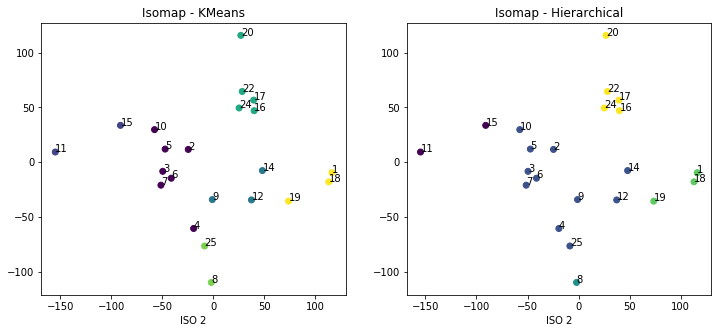

In [56]:
ncomponent = 2
f_has_iso = True
iso = manifold.Isomap(n_neighbors=5, n_components=ncomponent).fit(data)
Y = iso.transform(data)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(Y[:,0], Y[:,1], c=km_clusters)
plt.title('Isomap - KMeans')
plt.xlabel('ISO 1')
plt.xlabel('ISO 2')
for i in range(Y.shape[0]):
    plt.gca().annotate('%i'%(districts[i]), (Y[i,0]+0.01, Y[i,1]+0.01))

plt.subplot(1,2,2)
plt.scatter(Y[:,0], Y[:,1], c=ag_clusters)
plt.title('Isomap - Hierarchical')
plt.xlabel('ISO 1')
plt.xlabel('ISO 2')
for i in range(Y.shape[0]):
    plt.gca().annotate('%i'%(districts[i]), (Y[i,0]+0.01, Y[i,1]+0.01))

# Important Features 

## Decision Tree - KMeans

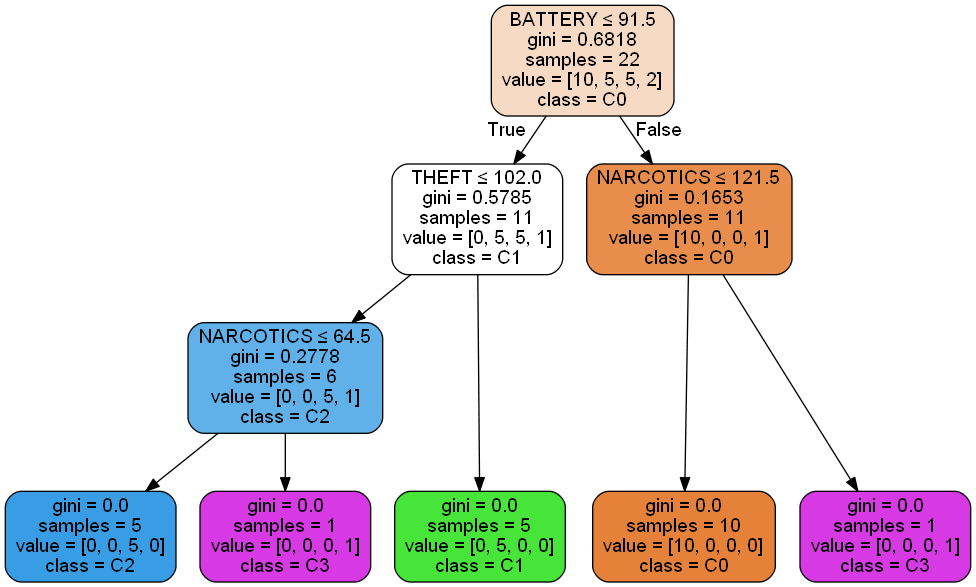

In [49]:
forest = tree.DecisionTreeClassifier(max_depth = 4)
forest.fit(data, km_clusters)
dot_data = StringIO()
tree.export_graphviz(forest, out_file=dot_data,
                     leaves_parallel=True,
                     feature_names=features,
                     class_names=['C'+str(i) for i in range(np.unique(km_clusters).shape[0])],
                     filled=True, rounded=True,
                     special_characters = True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

## Decision Tree - Hierarchical 

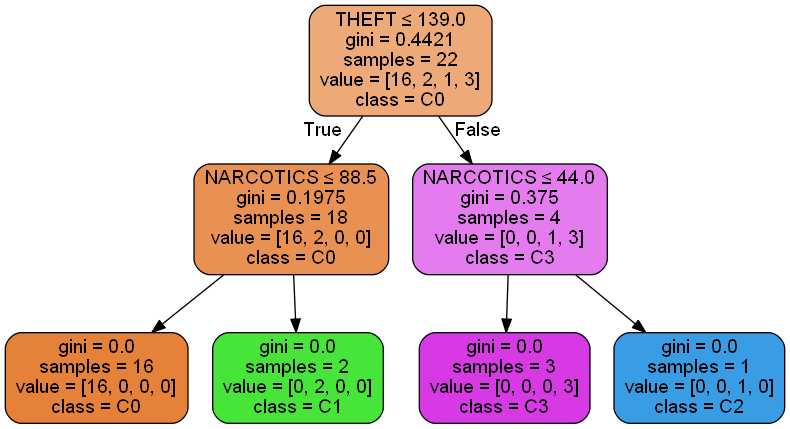

In [50]:
forest = tree.DecisionTreeClassifier(max_depth = 4)
forest.fit(data, ag_clusters)
dot_data = StringIO()
tree.export_graphviz(forest, out_file=dot_data,
                     leaves_parallel=True,
                     feature_names=features,
                     class_names=['C'+str(i) for i in range(np.unique(ag_clusters).shape[0])],
                     filled=True, rounded=True,
                     special_characters = True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())